In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logomaker
from Bio.PDB import PDBParser

In [2]:
# Dictionary to convert three-letter to one-letter amino acid codes
AMINO_ACID_DICT = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
    'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
    'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
}

# Define Kabat CDR regions by start and end numbers.
KABAT_CDR_DEFINITIONS = {
    # Heavy Chain
    'H1': (31, 35),
    'H2': (50, 65),
    'H3': (95, 102),
    # Light Chain
    'L1': (24, 34),
    'L2': (50, 56),
    'L3': (89, 97),
}

In [11]:
pwd

'/Users/johannesloffler/Flu/lateral_patch/Sequences'

In [28]:
#os.chdir('/Users/johannesloffler/Flu/lateral_patch/2F03/')
#os.chdir('/Users/johannesloffler/Flu/lateral_patch/1A02')
os.chdir('/Users/johannesloffler/Flu/lateral_patch/Sequences')

In [29]:
PDB_DIRECTORY = "./" 

In [30]:
def extract_cdr_from_renumbered_pdb(pdb_path):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("pdb", pdb_path)
    pdb_id = os.path.splitext(os.path.basename(pdb_path))[0]
    extracted_cdrs = {}
    for chain in structure[0]:
        chain_id = chain.id
        if chain_id not in ['H', 'L']: continue
        cdr_residues = {name: {} for name, _ in KABAT_CDR_DEFINITIONS.items() if chain_id in name}
        for residue in chain:
            res_name = residue.get_resname()
            if res_name not in AMINO_ACID_DICT: continue
            res_num, res_icode = residue.id[1], residue.id[2].strip()
            for cdr_name, (start, end) in KABAT_CDR_DEFINITIONS.items():
                if chain_id in cdr_name and start <= res_num <= end:
                    cdr_residues[cdr_name][(res_num, res_icode)] = AMINO_ACID_DICT[res_name]
        for cdr_name, res_map in cdr_residues.items():
            if not res_map: continue
            extracted_cdrs[cdr_name] = {
                'pdb_id': pdb_id, 'chain': chain_id, 'cdr': cdr_name,
                'length': len(res_map), 'residues': res_map
            }
    return list(extracted_cdrs.values())

def analyze_renumbered_pdbs(pdb_dir):
    if not os.path.isdir(pdb_dir):
        raise FileNotFoundError(f"Error: Directory not found at {pdb_dir}")
    all_cdr_data = []
    pdb_files = [f for f in os.listdir(pdb_dir) if f.endswith(('.pdb', '.ent'))]
    if not pdb_files:
        print(f"No PDB files found in '{pdb_dir}'.")
        return pd.DataFrame()
    print(f"Found {len(pdb_files)} PDB files. Starting analysis...")
    for file_name in pdb_files:
        all_cdr_data.extend(extract_cdr_from_renumbered_pdb(os.path.join(pdb_dir, file_name)))
    print("Analysis complete.")
    return pd.DataFrame(all_cdr_data)

# --- Plotting Functions (unchanged, but shown for completeness) ---
def plot_cdr_lengths(df):
    if df.empty: return
    print("Generating CDR length plots...")
    plt.figure(figsize=(18, 10))
    plt.suptitle('Distribution of CDR Lengths (Kabat Scheme)', fontsize=20, weight='bold')
    cdrs_to_plot = sorted(df['cdr'].unique())
    for i, cdr in enumerate(cdrs_to_plot, 1):
        ax = plt.subplot(2, 3, i)
        subset = df[df['cdr'] == cdr]
        sns.countplot(x='length', data=subset, palette='viridis', order=sorted(subset['length'].unique()), hue='length', legend=False, ax=ax)
        ax.set_title(f'{cdr} Lengths', fontsize=14)
        ax.set_xlabel('Biological Length (amino acids)')
        ax.set_ylabel('Count')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("cdr_length_distribution.png", dpi=300)
    plt.show()

def plot_sequence_logos(df):
    if df.empty: return
    print("Generating aligned sequence logos...")
    for cdr in sorted(df['cdr'].unique()):
        subset_df = df[df['cdr'] == cdr].copy()
        if subset_df.empty: continue
        all_positions = set().union(*(res_map.keys() for res_map in subset_df['residues']))
        if not all_positions: continue
        sorted_positions = sorted(list(all_positions))
        aligned_sequences = ["".join([res_map.get(pos, '-') for pos in sorted_positions]) for res_map in subset_df['residues']]
        counts_df = logomaker.alignment_to_matrix(sequences=aligned_sequences)
        logo = logomaker.Logo(counts_df, color_scheme='skylign_protein', figsize=(max(8, len(sorted_positions) * 0.5), 4))
        logo.style_spines(visible=False)
        logo.ax.set_ylabel('Bits')
        logo.ax.set_title(f'Sequence Logo for {cdr}', fontsize=16, weight='bold')
        position_labels = [f"{num}{icode}" for num, icode in sorted_positions]
        logo.ax.set_xticks(range(len(position_labels)))
        logo.ax.set_xticklabels(position_labels, rotation=90, fontsize=10)
        plt.tight_layout()
        plt.savefig(f"{cdr}_sequence_logo.png", dpi=300)
        plt.show()

Found 2 PDB files. Starting analysis...
Analysis complete.

--- CDR Data Summary (with Aligned Sequences) ---
                            pdb_id chain cdr  length           sequence
3  1A02_single_AB_kabat_renumbered     H  H1       5              SYAMS
6  2F03_single_AB_kabat_renumbered     H  H1       5              QFAMT
4  1A02_single_AB_kabat_renumbered     H  H2      17  AISGSGGSTYYADSVKG
7  2F03_single_AB_kabat_renumbered     H  H2      17  AINADGAITYYADSVKG
5  1A02_single_AB_kabat_renumbered     H  H3      14     YDSSGHHYVRRMHF

✅ Aligned summary table saved to 'cdr_summary_aligned.csv'
Generating CDR length plots...


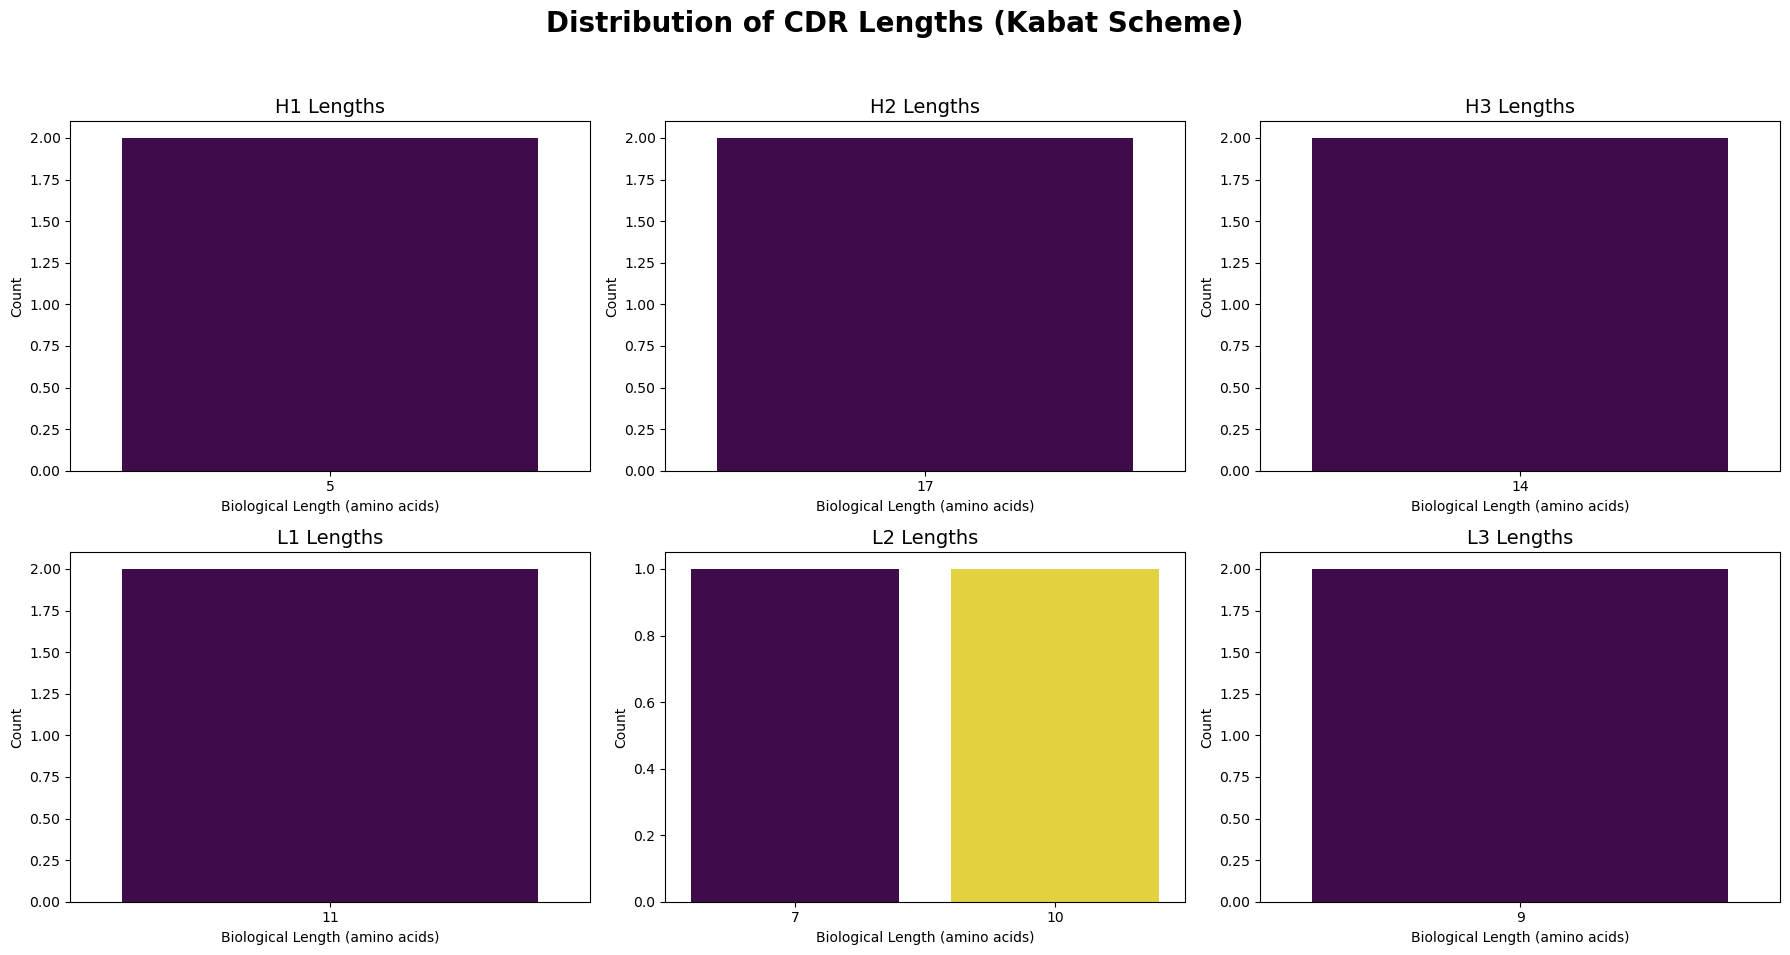

Generating aligned sequence logos...


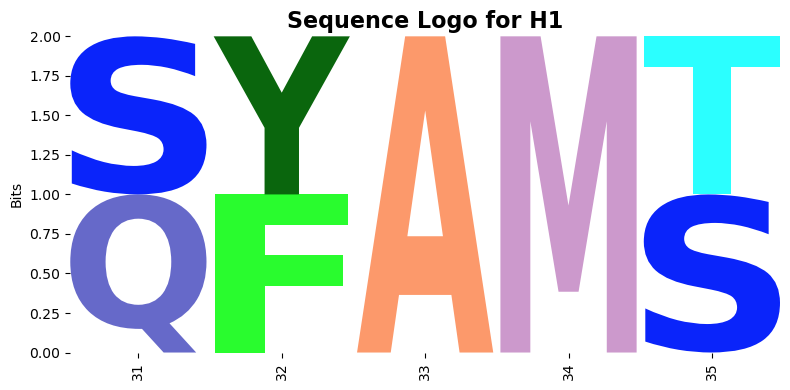

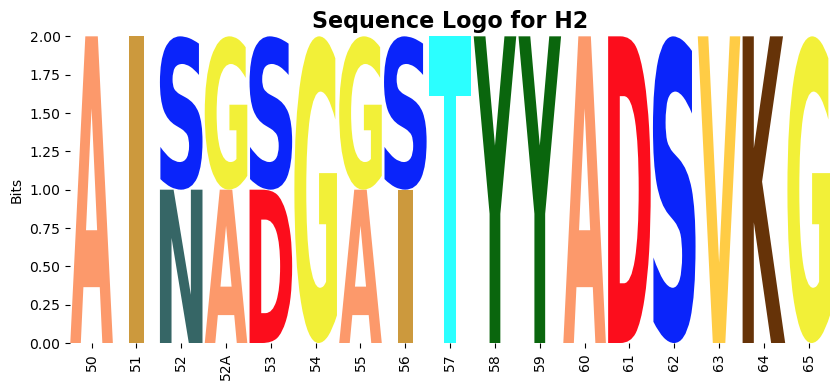

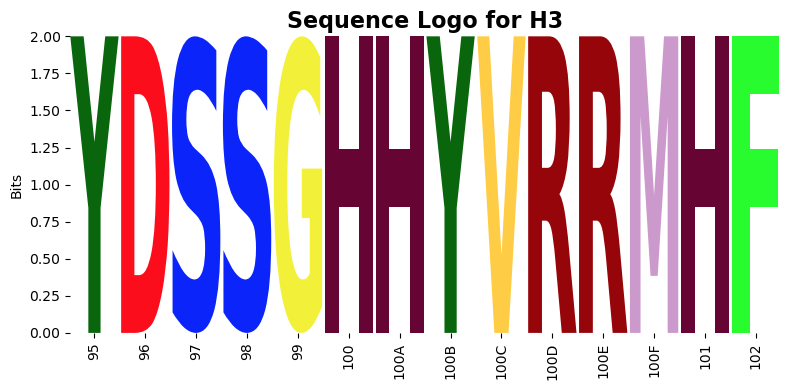

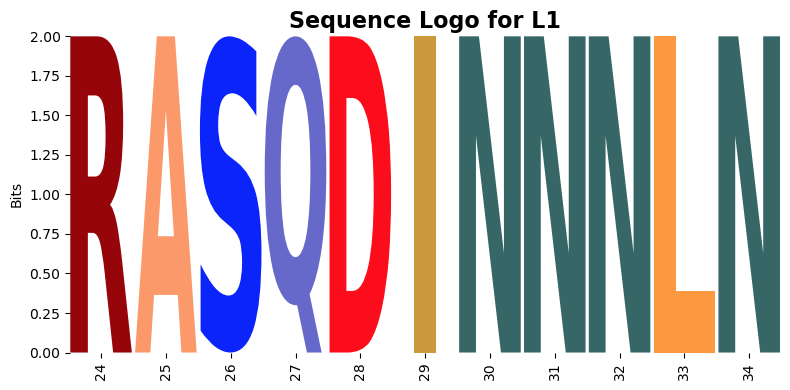

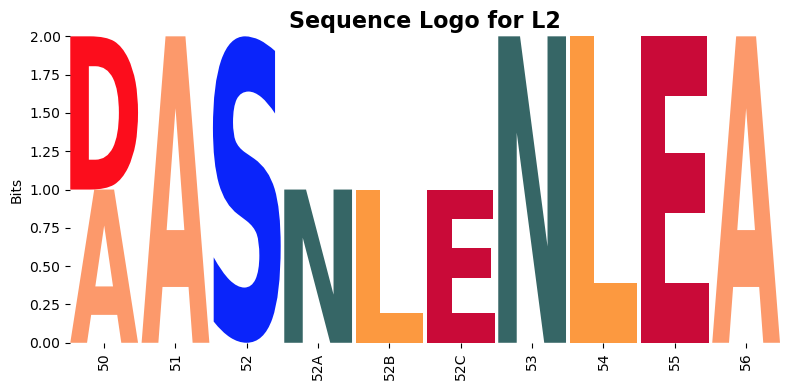

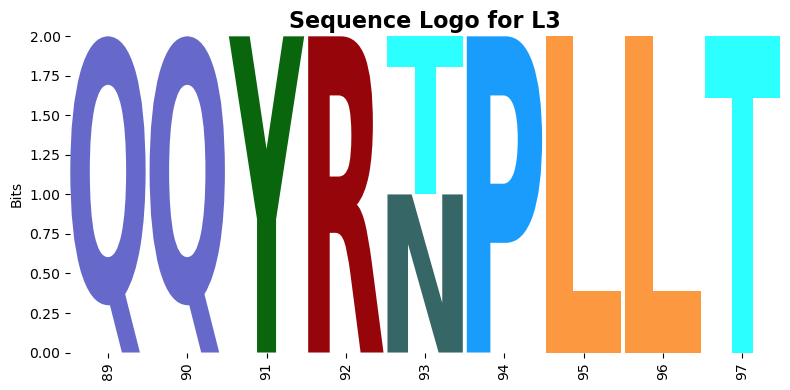


✅ All plots saved to the current directory.


In [31]:
if __name__ == "__main__":
    try:
        cdr_df = analyze_renumbered_pdbs(PDB_DIRECTORY)
        if not cdr_df.empty:
            # **NEW**: Align sequences within each CDR group before saving
            aligned_data_list = []
            for cdr_name, group in cdr_df.groupby('cdr'):
                group = group.copy()
                # Find the union of all positions for this CDR type
                all_positions = set().union(*(res_map.keys() for res_map in group['residues']))
                sorted_positions = sorted(list(all_positions))
                
                # Create the new aligned sequence column
                group['sequence'] = group['residues'].apply(
                    lambda res_map: "".join([res_map.get(pos, '-') for pos in sorted_positions])
                )
                aligned_data_list.append(group)
            
            # Combine the aligned groups back into one DataFrame
            aligned_df = pd.concat(aligned_data_list)
            
            # Create a clean summary DataFrame for export
            summary_df = aligned_df[['pdb_id', 'chain', 'cdr', 'length', 'sequence']]
            
            print("\n--- CDR Data Summary (with Aligned Sequences) ---")
            print(summary_df.head())
            
            # Save the summary DataFrame to a CSV file
            output_filename = "cdr_summary_aligned.csv"
            summary_df.to_csv(output_filename, index=False)
            print(f"\n✅ Aligned summary table saved to '{output_filename}'")

            # Generate plots
            plot_cdr_lengths(cdr_df) # Plotting original biological lengths
            plot_sequence_logos(cdr_df) # Plotting logos still requires original 'residues' map
            
            print("\n✅ All plots saved to the current directory.")
        else:
            print("\nNo CDR data was extracted.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [32]:
df = pd.read_csv("cdr_summary_aligned.csv")

In [33]:
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interactive_output, VBox
from IPython.display import display, clear_output

if df is not None:
    # --- Create Widgets ---
    
    # Get options for the widgets from the dataframe
    cdr_options = ['All'] + sorted(df['cdr'].unique())
    min_len, max_len = int(df['length'].min()), int(df['length'].max())

    # Create the dropdown and slider
    cdr_widget = widgets.Dropdown(
        options=cdr_options, 
        value='All', 
        description='CDR Loop:'
    )
    
    length_widget = widgets.IntRangeSlider(
        value=[min_len, max_len], 
        min=min_len, 
        max=max_len, 
        description='Length:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )

    # Output widget to display the results
    output_widget = widgets.Output()

    # --- Filtering Function ---
    def filter_data(cdr, length_range):
        with output_widget:
            clear_output(wait=True) # Clear the previous table
            
            # Start with a copy of the original dataframe
            filtered_df = df.copy()
            
            # Apply CDR filter if 'All' is not selected
            if cdr != 'All':
                filtered_df = filtered_df[filtered_df['cdr'] == cdr]
            
            # Apply length filter
            filtered_df = filtered_df[
                (filtered_df['length'] >= length_range[0]) & 
                (filtered_df['length'] <= length_range[1])
            ]
            
            # Display the result, sorted by length
            display(filtered_df.sort_values(by='length', ascending=False))

    # --- Display Everything ---
    
    # Link the function to the widgets
    interactive_output(filter_data, {'cdr': cdr_widget, 'length_range': length_widget})

    # Display the UI
    display(VBox([
        widgets.HTML("<h3>CDR Data Explorer</h3>"),
        cdr_widget,
        length_widget,
        output_widget
    ]))


In [8]:
CSV_FILE_PATH = "cdr_summary_aligned.csv"
try:
    df = pd.read_csv(CSV_FILE_PATH)
    print(f"✅ Successfully loaded '{CSV_FILE_PATH}'. The interactive widget is ready below.")
except FileNotFoundError:
    print(f"❌ Error: The file '{CSV_FILE_PATH}' was not found.")
    print("Please run the alignment script first to generate this summary file.")
    df = None

if df is not None:
    # --- Create Widgets ---
    cdr_options = ['All'] + sorted(df['cdr'].unique())
    min_len, max_len = int(df['length'].min()), int(df['length'].max())

    cdr_widget = widgets.Dropdown(options=cdr_options, value='All', description='CDR Loop:')
    length_widget = widgets.IntRangeSlider(
        value=[min_len, max_len], min=min_len, max=max_len, description='Length:',
        style={'description_width': 'initial'}, layout=widgets.Layout(width='50%')
    )
    output_widget = widgets.Output()

    # --- Filtering and Plotting Function ---
    def filter_and_plot(cdr, length_range):
        with output_widget:
            clear_output(wait=True) # Clear previous output
            
            # Apply filters
            filtered_df = df[
                (df['length'] >= length_range[0]) & 
                (df['length'] <= length_range[1])
            ]
            if cdr != 'All':
                filtered_df = filtered_df[filtered_df['cdr'] == cdr]

            # Display the filtered table
            print(f"Displaying {len(filtered_df)} sequences.")
            display(filtered_df.sort_values(by='length', ascending=False))

            # **NEW**: Generate and display a sequence logo if a specific CDR is selected
            if cdr != 'All' and not filtered_df.empty:
                print("\n--- Dynamic Sequence Logo ---")
                
                # Get the list of aligned sequences from the dataframe
                sequences = filtered_df['sequence'].tolist()
                
                # Create the count matrix for Logomaker
                counts_df = logomaker.alignment_to_matrix(sequences=sequences)
                
                # Plot the logo
                logo = logomaker.Logo(counts_df, 
                                      color_scheme='skylign_protein', 
                                      figsize=(max(8, len(sequences[0]) * 0.4), 4))
                
                logo.style_spines(visible=False)
                logo.ax.set_ylabel('Bits')
                logo.ax.set_title(f'Sequence Logo for selected {cdr} loops', fontsize=16, weight='bold')
                
                # Use simple integer indexing for the x-axis
                plt.show()

    # --- Display Everything ---
    interactive_output(filter_and_plot, {'cdr': cdr_widget, 'length_range': length_widget})
    display(VBox([
        widgets.HTML("<h3>CDR Data Explorer with Dynamic Logo</h3>"),
        cdr_widget,
        length_widget,
        output_widget
    ]))

✅ Successfully loaded 'cdr_summary_aligned.csv'. The interactive widget is ready below.


In [9]:
from ipywidgets import interactive_output, VBox, HBox

def calculate_percent_identity(seq1, seq2):
    """Calculates the percent identity between two pre-aligned strings."""
    matches = 0
    # Assumes seq1 and seq2 are the same length
    for char1, char2 in zip(seq1, seq2):
        if char1 == char2:
            matches += 1
    return (matches / len(seq1)) * 100.0

if df is not None:
    # --- Create Widgets ---
    cdr_options = ['All'] + sorted(df['cdr'].unique())
    min_len, max_len = int(df['length'].min()), int(df['length'].max())

    cdr_widget = widgets.Dropdown(options=cdr_options, value='All', description='CDR Loop:')
    length_widget = widgets.IntRangeSlider(
        value=[min_len, max_len], min=min_len, max=max_len, description='Length (biological):',
        style={'description_width': 'initial'}, layout=widgets.Layout(width='50%')
    )
    output_widget = widgets.Output()

    # --- Filtering, Plotting, and Similarity Function ---
    def filter_and_plot(cdr, length_range):
        with output_widget:
            clear_output(wait=True)
            
            # Apply filters
            filtered_df = df[
                (df['length'] >= length_range[0]) & 
                (df['length'] <= length_range[1])
            ]
            if cdr != 'All':
                filtered_df = filtered_df[filtered_df['cdr'] == cdr]

            # Display the filtered table
            print(f"Displaying {len(filtered_df)} sequences.")
            display(filtered_df.sort_values(by='length', ascending=False))

            # Generate and display a sequence logo
            if cdr != 'All' and not filtered_df.empty:
                print("\n--- Dynamic Sequence Logo ---")
                sequences = filtered_df['sequence'].tolist()
                counts_df = logomaker.alignment_to_matrix(sequences=sequences)
                logo = logomaker.Logo(counts_df, color_scheme='skylign_protein', figsize=(max(8, len(sequences[0]) * 0.4), 4))
                logo.style_spines(visible=False)
                logo.ax.set_ylabel('Bits')
                logo.ax.set_title(f'Sequence Logo for selected {cdr} loops', fontsize=16, weight='bold')
                plt.show()

            # Calculate and display pairwise sequence similarity
            if cdr != 'All' and len(filtered_df) > 1:
                print("\n--- Pairwise Percent Identity ---")
                
                ids = filtered_df.index.tolist()
                sequences = filtered_df['sequence'].tolist()
                num_seqs = len(sequences)
                
                similarity_df = pd.DataFrame(index=ids, columns=ids, dtype=float)

                # Calculate pairwise similarity using our new function
                for i in range(num_seqs):
                    for j in range(i, num_seqs):
                        similarity = calculate_percent_identity(sequences[i], sequences[j])
                        similarity_df.iloc[i, j] = similarity
                        similarity_df.iloc[j, i] = similarity
                
                styled_matrix = similarity_df.style.background_gradient(cmap='viridis', vmin=40, vmax=100)\
                                                    .format('{:.1f}%', na_rep="-")
                display(styled_matrix)

    # --- Display Everything ---
    interactive_output(filter_and_plot, {'cdr': cdr_widget, 'length_range': length_widget})
    display(VBox([
        widgets.HTML("<h3>CDR Data Explorer</h3>"),
        HBox([cdr_widget, length_widget]),
        output_widget
    ]))

In [10]:
pwd

'/Users/johannesloffler/Flu/lateral_patch/Sequences'